Loaded 240 total experiments
All Methods: ['lasso' 'lassonet' 'nimo' 'random_forest' 'neural_net']
All Datasets: ['A' 'B' 'C' 'D' 'breast_cancer' 'pima' 'bank_marketing' 'adult_income']

Filtered to 120 real experiments
Real Methods: ['lasso' 'lassonet' 'nimo' 'random_forest' 'neural_net']
Real Datasets: ['breast_cancer' 'pima' 'bank_marketing' 'adult_income']


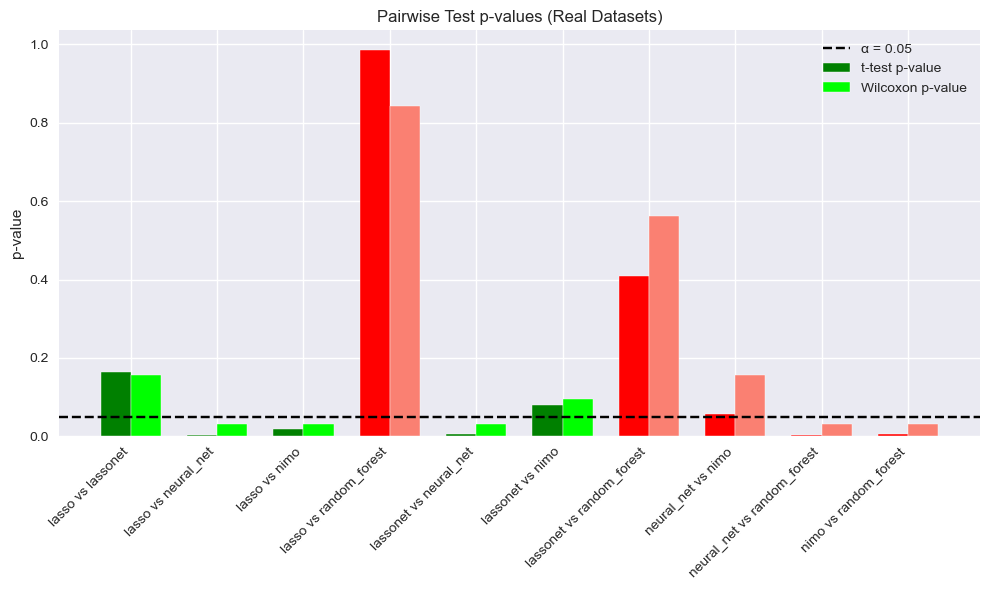

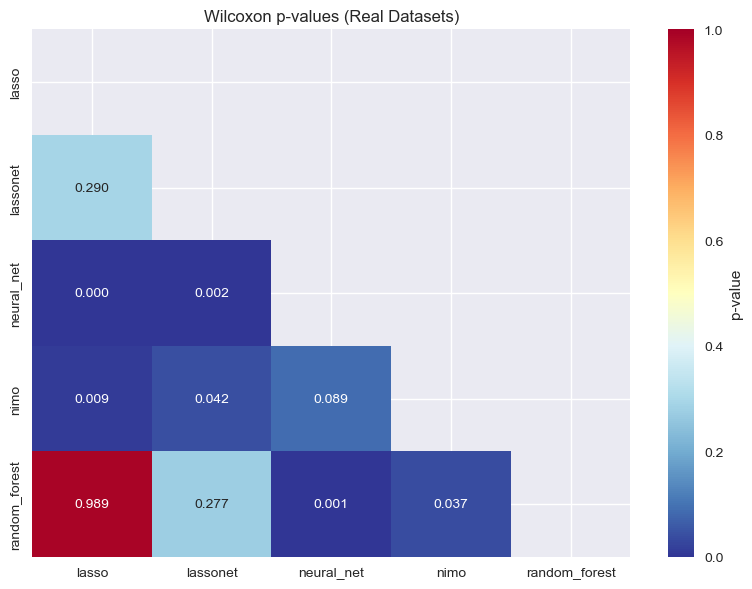

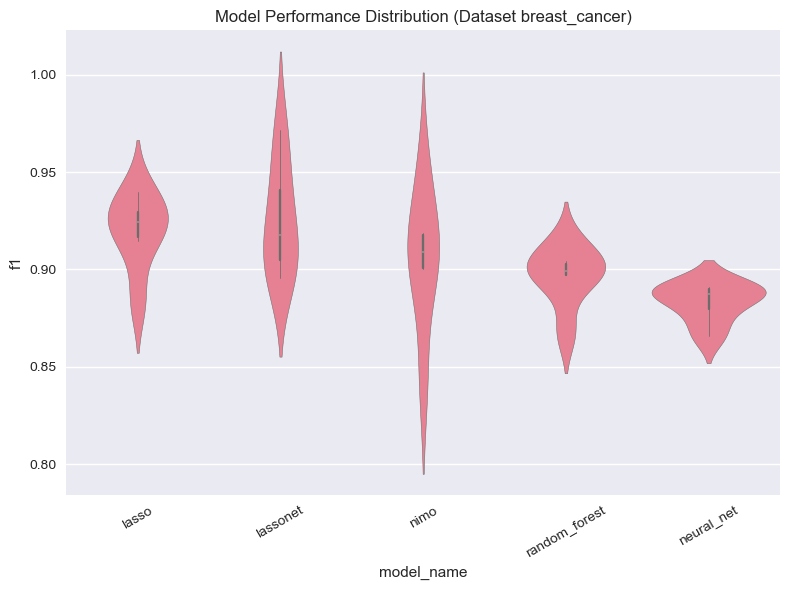

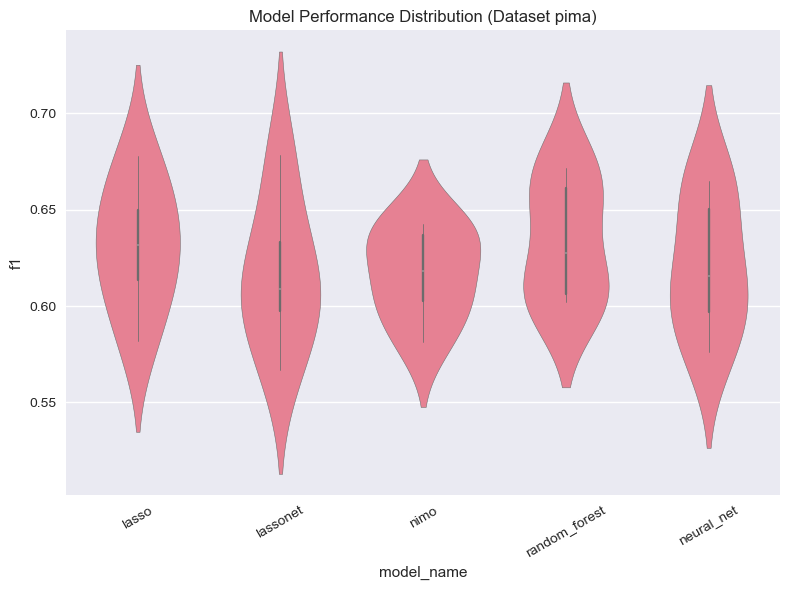

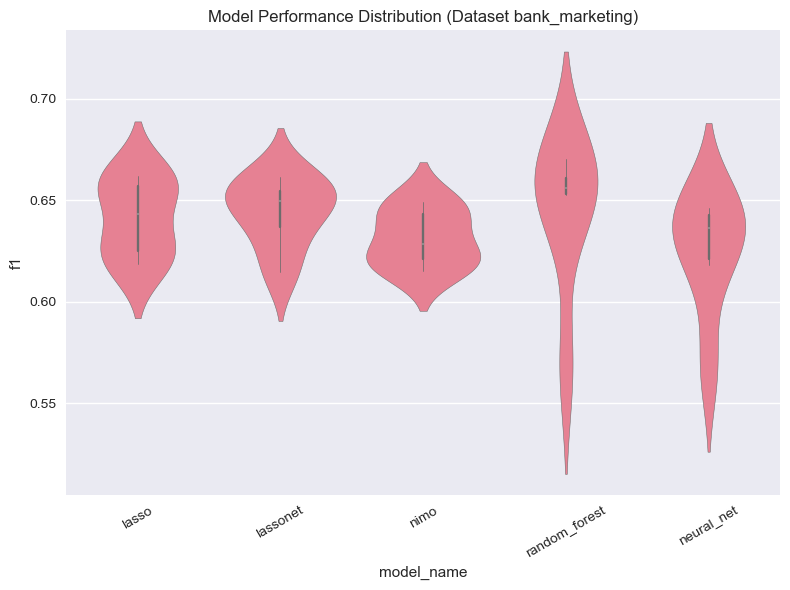

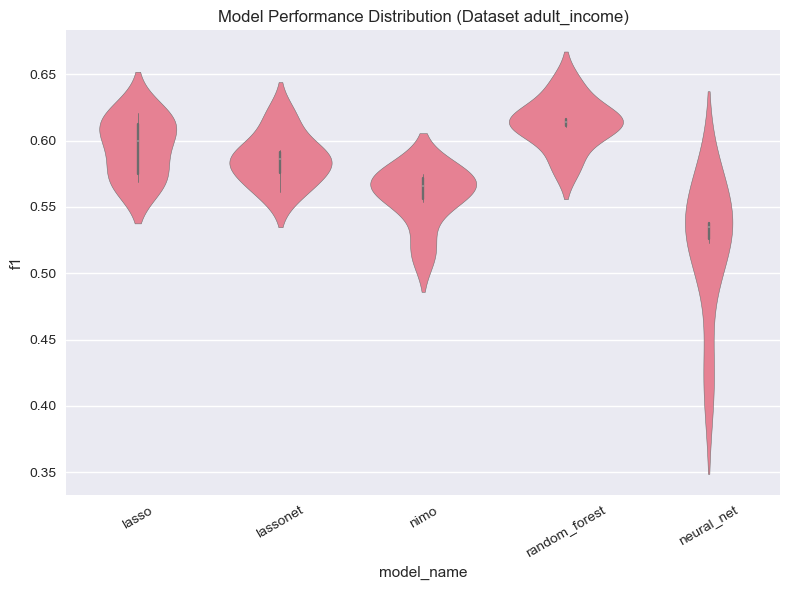

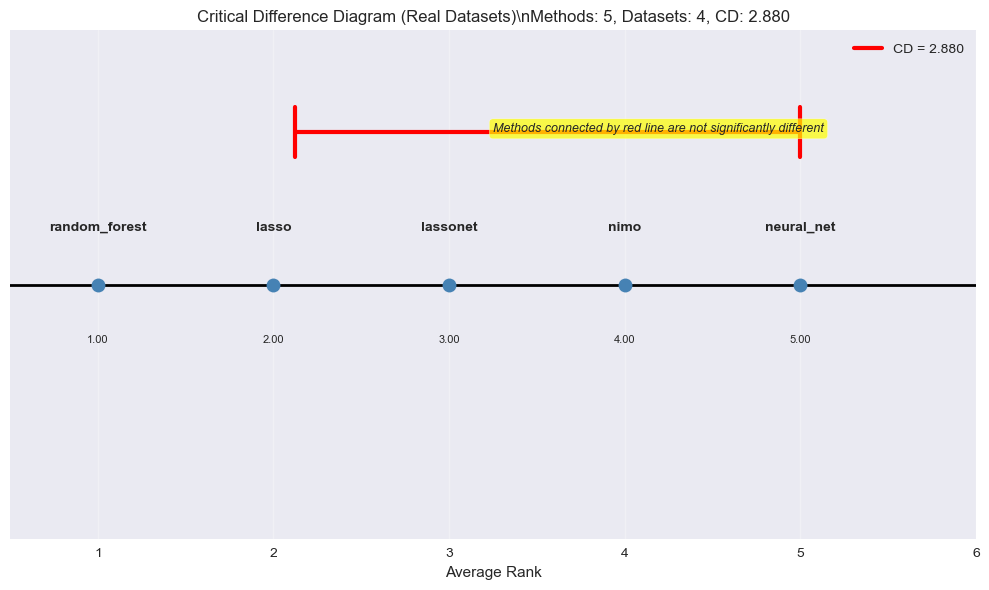

\nReal Datasets - Critical Difference Analysis:
  Methods: 5
  Datasets: 4
  Critical Difference: 2.880
  Mean ranks: {'random_forest': 1.0, 'lasso': 2.0, 'lassonet': 3.0, 'nimo': 4.0, 'neural_net': 5.0}


In [4]:
# Wilcoxon Statistical Comparison Notebook - Real Datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations
import scikit_posthocs as sp
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Set style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# === Load data ===
results_path = Path("../../../results/all/experiment_results1.csv")
df = pd.read_csv(results_path)

print(f"Loaded {len(df)} total experiments")
print("All Methods:", df["model_name"].unique())
print("All Datasets:", df["dataset_id"].unique())

# Filter for real datasets only (exclude synthetic A, B, C, D)
synthetic_ids = ["A", "B", "C", "D"]
df_real = df[~df["dataset_id"].isin(synthetic_ids)]

print(f"\nFiltered to {len(df_real)} real experiments")
print("Real Methods:", df_real["model_name"].unique())
print("Real Datasets:", df_real["dataset_id"].unique())

# ============================================================
# === NEW: Pairwise p-value barplot across all iterations ===
# ============================================================
# Pivot: iteration × model
f1_pivot = df_real.pivot_table(index="iteration", columns="model_name", values="f1")

models = f1_pivot.columns.tolist()
results = []
for m1, m2 in combinations(models, 2):
    x, y = f1_pivot[m1].dropna(), f1_pivot[m2].dropna()
    if len(x) == len(y) and len(x) > 0:
        # Paired t-test
        t_stat, t_p = stats.ttest_rel(x, y)
        # Wilcoxon
        try:
            w_stat, w_p = stats.wilcoxon(x, y)
        except ValueError:
            w_p = np.nan
        results.append({
            "pair": f"{m1} vs {m2}",
            "t_p": t_p,
            "w_p": w_p
        })

results_df = pd.DataFrame(results)

# Plot barplot
x_labels = results_df["pair"]
x_pos = np.arange(len(x_labels))
width = 0.35

# Compute mean F1 differences for coloring
diffs = []
for m1, m2 in combinations(models, 2):
    diff = f1_pivot[m1].mean() - f1_pivot[m2].mean()
    diffs.append(diff)

results_df["mean_diff"] = diffs

# Color: green if method1 > method2, red otherwise
colors_t = ["green" if d > 0 else "red" for d in results_df["mean_diff"]]
colors_w = ["lime" if d > 0 else "salmon" for d in results_df["mean_diff"]]

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x_pos - width/2, results_df["t_p"], width, color=colors_t, label="t-test p-value")
ax.bar(x_pos + width/2, results_df["w_p"], width, color=colors_w, label="Wilcoxon p-value")
ax.axhline(0.05, color="black", linestyle="--", label="α = 0.05")
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df["pair"], rotation=45, ha="right")
ax.set_ylabel("p-value")
ax.set_title("Pairwise Test p-values (Real Datasets)")
ax.legend()
plt.tight_layout()
plt.show()

# === Helper: Wilcoxon pairwise ===
def wilcoxon_pairwise(data, metric="f1"):
    methods = data["model_name"].unique()
    results = []
    for m1, m2 in combinations(methods, 2):
        scores1 = data[data["model_name"] == m1][metric].reset_index(drop=True)
        scores2 = data[data["model_name"] == m2][metric].reset_index(drop=True)
        if len(scores1) == len(scores2) and len(scores1) > 0:
            stat, p = stats.wilcoxon(scores1, scores2)
            results.append({"method1": m1, "method2": m2, "p_value": p})
    return pd.DataFrame(results)

# === 1. Per dataset Wilcoxon ===
all_results = {}
for dataset in df_real["dataset_id"].unique():
    subset = df_real[df_real["dataset_id"] == dataset]
    res = wilcoxon_pairwise(subset, metric="f1")
    all_results[dataset] = res

# === 2. Group-level Wilcoxon ===
group_results = {}
subset = df_real
res = wilcoxon_pairwise(subset, metric="f1")
group_results["Real"] = res

# === 3. p-value Heatmap ===
def plot_heatmap(res, title):
    methods = sorted(set(res["method1"]) | set(res["method2"]))
    mat = np.ones((len(methods), len(methods)))
    idx = {m: i for i, m in enumerate(methods)}
    for _, row in res.iterrows():
        i, j = idx[row["method1"]], idx[row["method2"]]
        mat[i, j] = mat[j, i] = row["p_value"]

    mask = np.triu(np.ones_like(mat, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.heatmap(mat, mask=mask, annot=True, fmt=".3f",
                cmap="RdYlBu_r", vmin=0, vmax=1,
                xticklabels=methods, yticklabels=methods,
                cbar_kws={"label": "p-value"})
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Heatmap for Real group
plot_heatmap(group_results["Real"], "Wilcoxon p-values (Real Datasets)")

# === 4. Box/Violin Plots per real dataset ===
def plot_boxplots(data, dataset_id):
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, x="model_name", y="f1", inner="box")
    plt.title(f"Model Performance Distribution (Dataset {dataset_id})")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Plot performance distribution for each real dataset
real_dataset_ids = df_real["dataset_id"].unique()
for d in real_dataset_ids:
    plot_boxplots(df_real[df_real["dataset_id"] == d], d)

# === 5. Critical Difference Diagram (custom implementation) ===
def critical_difference_plot(data, group_name):
    """
    Custom Critical Difference diagram implementation
    Replaces Orange.evaluation.compute_CD and graph_ranks
    """
    # Calculate mean ranks for each method
    mean_ranks = data.groupby("model_name")["f1"].mean().rank(ascending=False)
    methods = list(mean_ranks.index)
    ranks = mean_ranks.values

    # Calculate Critical Difference using Nemenyi test
    n_datasets = len(data["dataset_id"].unique())
    n_methods = len(methods)

    # Critical difference for Nemenyi test (alpha=0.05)
    # CD = q_alpha * sqrt(k*(k+1)/(6*N))
    # where q_alpha ≈ 2.576 for alpha=0.05, k=methods, N=datasets
    q_alpha = 2.576  # For alpha=0.05
    cd = q_alpha * np.sqrt(n_methods * (n_methods + 1) / (6 * n_datasets))

    # Create the CD diagram
    fig, ax = plt.subplots(figsize=(10, 6))

    # Sort methods by rank (best to worst)
    sorted_indices = np.argsort(ranks)
    sorted_methods = [methods[i] for i in sorted_indices]
    sorted_ranks = ranks[sorted_indices]

    # Plot horizontal line
    y_pos = 0.5
    ax.plot([0, max(sorted_ranks) + 1], [y_pos, y_pos], 'k-', linewidth=2)

    # Plot method points and labels
    for i, (method, rank) in enumerate(zip(sorted_methods, sorted_ranks)):
        ax.plot(rank, y_pos, 'o', markersize=10, color='steelblue')
        ax.text(rank, y_pos + 0.1, method, ha='center', va='bottom', fontsize=10, fontweight='bold')
        ax.text(rank, y_pos - 0.1, f'{rank:.2f}', ha='center', va='top', fontsize=8)

    # Add CD line
    ax.plot([max(sorted_ranks) - cd, max(sorted_ranks)], [y_pos + 0.3, y_pos + 0.3], 'r-', linewidth=3, label=f'CD = {cd:.3f}')
    ax.plot([max(sorted_ranks) - cd, max(sorted_ranks) - cd], [y_pos + 0.25, y_pos + 0.35], 'r-', linewidth=3)
    ax.plot([max(sorted_ranks), max(sorted_ranks)], [y_pos + 0.25, y_pos + 0.35], 'r-', linewidth=3)

    # Styling
    ax.set_xlim(0.5, max(sorted_ranks) + 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Average Rank')
    ax.set_title(f'Critical Difference Diagram ({group_name})\\n'
                f'Methods: {n_methods}, Datasets: {n_datasets}, CD: {cd:.3f}')
    ax.legend()
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis='x')

    # Add interpretation text
    ax.text(0.5, 0.8, 'Methods connected by red line are not significantly different',
            transform=ax.transAxes, fontsize=9, style='italic',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\\n{group_name} - Critical Difference Analysis:")
    print(f"  Methods: {n_methods}")
    print(f"  Datasets: {n_datasets}")
    print(f"  Critical Difference: {cd:.3f}")
    print(f"  Mean ranks: {dict(zip(sorted_methods, sorted_ranks))}")

# Run CD analysis for Real group only
critical_difference_plot(df_real, "Real Datasets")
